# ETL Workflow for Forest Cover Change Analysis in the Congo Basin.

In [36]:
import os
import shutil
from datetime import datetime
import rasterio
import pystac
from pystac_client import Client
import geopandas as gpd
from shapely.geometry import box, Polygon, shape
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt 
import zarr
import dask
from dask.distributed import Client
import dask.array as da
from dask.diagnostics import ProgressBar

In [37]:
# Better visualization
plt.style.use('ggplot')

In [38]:
DATA_DIR = 'kimongo_ndvi_archive'
ZARR_STORE = os.path.join(DATA_DIR, 'kimongo.zarr')

In [4]:
client = Client('127.0.0.1:8787')

CommClosedError: in <TCP (closed)  local=tcp://127.0.0.1:49377 remote=tcp://127.0.0.1:8787>: ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [39]:
def log_progress(message): 
    timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
    now = datetime.now() # get current timestamp 
    timestamp = now.strftime(timestamp_format) 
    with open("./log/ndvi_log.txt","a") as f: 
        f.write(timestamp + ' : ' + message + '\n')

In [8]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
else :
    pass
    # shutil.rmtree(DATA_DIR)
    # os.makedirs(DATA_DIR)

In [57]:
# Create the STAC Catalog

log_progress('Initiating create_baseline_stac_item process')

catalog = pystac.Catalog(
    id="kimongo-catalog",
    title="Kimongo Sentinel-2 Catalog",
    description="STAC Catalog for Sentinel-2 Baseline Product in the Kimongo Area.",
)

In [59]:
# Function to parse ISO 8601 date strings with 'Z'
def parse_iso_date(iso_date):
    return datetime.strptime(iso_date.replace("Z", "+00:00"), "%Y-%m-%dT%H:%M:%S.%f%z")

# Create a STAC Item for the product
baseline_stac_item = pystac.Item(
    id="S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE",
    geometry={
        "type": "Polygon",
        "coordinates": [
            [
            [12.834091,-4.56342],
            [12.834091,-4.39776],
            [13.07579,-4.39776],
            [13.07579,-4.56342],
            [12.834091,-4.56342]
        ]
    ]
    },
    bbox=(12.834091, -4.56342, 13.07579, -4.39776),
    datetime=parse_iso_date("2018-11-17T09:12:41.024000Z"),
    properties={
        "platform": "SENTINEL-2",
        "cloud_coverage": 15.5165,
        "beginning_datetime": "2018-11-17T09:12:41.024000Z",
        "ending_datetime": "2018-11-17T09:12:41.024000Z",
        "absolute_orbit": 17779,
        "instrument": "MSI",
        "acquisition_mode": "INS-NOBS",
        "processing_level": "S2MSI2A",
        "tile_id": "33MTR",
        "spatial_resolution": 60.0,
        "published": "2020-11-29T23:50:08.138215Z",
        "size": "< 1MB",
        "product_id": "https://zipper.dataspace.copernicus.eu/odata/v1/Products(2f9d2507-208f-5e71-a973-18f02458d48f)/$value",
        "download_link": "https://link.dataspace.copernicus.eu/yxsh"
    }
)

# Use S3 path as the asset href
baseline_stac_item.add_asset(
        key="data",
        asset=pystac.Asset(
            href="/eodata/Sentinel-2/MSI/L2A/2018/11/17/S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE",
            media_type=pystac.MediaType.GEOTIFF,
            title="Sentinel-2 S3 Data"
        )
    )

baseline_stac_item.add_asset(
    key="BaseB04",
    asset=pystac.Asset(
        href="./Browser_images/SENTINEL-2/Baseline/2018-07-31-00_00_2023-07-30-23_59_Sentinel-2_L2A_B04_(Raw).tiff",
        media_type=pystac.MediaType.TIFF,
        title="Sentinel-2 Baseline B04"
    )
)

baseline_stac_item.add_asset(
    key="BaseB08",
    asset=pystac.Asset(
        href="./Browser_images/SENTINEL-2/Baseline/2018-07-31-00_00_2023-07-30-23_59_Sentinel-2_L2A_B08_(Raw).tiff",
        media_type=pystac.MediaType.TIFF,
        title="Sentinel-2 Baseline B08"
    )
)



In [60]:
# Add the item to the catalog
catalog.add_item(baseline_stac_item)

# Create a directory for the STAC catalog if it doesn't exist
output_directory = './stac_catalog'
os.makedirs(output_directory, exist_ok=True)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the output file path with datetime
output_file_path = os.path.join(output_directory, f'baseline_catalog-{current_datetime}')

# Normalize hrefs and save the STAC catalog to a file
catalog.normalize_hrefs(output_directory)
catalog.save(catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED, dest_href=output_file_path)

print(f"STAC catalog saved to {output_file_path}")

print("STAC Item created:")

display(baseline_stac_item.to_dict())

log_progress('Baseline stac creation complete. Initiating process_baseline_analysis')


STAC catalog saved to ./stac_catalog\baseline_catalog-20240910_154345
STAC Item created:


{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE',
 'properties': {'platform': 'SENTINEL-2',
  'cloud_coverage': 15.5165,
  'beginning_datetime': '2018-11-17T09:12:41.024000Z',
  'ending_datetime': '2018-11-17T09:12:41.024000Z',
  'absolute_orbit': 17779,
  'instrument': 'MSI',
  'acquisition_mode': 'INS-NOBS',
  'processing_level': 'S2MSI2A',
  'tile_id': '33MTR',
  'spatial_resolution': 60.0,
  'published': '2020-11-29T23:50:08.138215Z',
  'size': '< 1MB',
  'product_id': 'https://zipper.dataspace.copernicus.eu/odata/v1/Products(2f9d2507-208f-5e71-a973-18f02458d48f)/$value',
  'download_link': 'https://link.dataspace.copernicus.eu/yxsh',
  'datetime': '2018-11-17T09:12:41.024000Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[12.834091, -4.56342],
    [12.834091, -4.39776],
    [13.07579, -4.39776],
    [13.07579, -4.56342],
    [12.834091, -4.56342]]]},
 'links': [{'rel': 'root',
   'href': '../catalog.j

********************************* Baseline Catalog Created ***************************************

In [61]:
catalog_path = 'stac_catalog/baseline_catalog-20240910_154345/catalog.json'
catalog = pystac.Catalog.from_file(catalog_path)

print(f"Catalog ID: {catalog.id}")

Catalog ID: kimongo-catalog


In [62]:
items = list(catalog.get_items()) 
print(f"Number of items: {len(items)}")

# Get the list of items
items = list(catalog.get_items())

# Print out the available item IDs
for item in items:
    print(item.id) 

Number of items: 1
S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE


In [63]:


# Replace with the actual item ID you want to access
item_id = 'S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE'  # Adjust as needed
baseline_stac_item = catalog.get_item(item_id)

display(baseline_stac_item)


<Item id=S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE>

In [48]:
# Function to calculate NDVI
@dask.delayed
def calculate_ndvi(baseline_stac_item):

    red_href = baseline_stac_item.assets.get("BaseB04").href  # Baseline Red band
    nir_href = baseline_stac_item.assets.get("BaseB08").href  # Baseline NIR band

    if not red_href or not nir_href:
        log_progress("Red or NIR band not found in the Baseline STAC item: calculate_ndvi")
        
        client.close()
        
    else:
        try:
            log_progress(f"Processing analysis for {baseline_stac_item.id}...")

            red = rioxarray.open_rasterio(red_href, chunks="auto")
            nir = rioxarray.open_rasterio(nir_href, chunks="auto")

            # Check the number of bands
            log_progress(f"Red band number of bands: {red.shape[0]}")
            log_progress(f"NIR band number of bands: {nir.shape[0]}")
            
            # Calculate NDVI
            ndvi = (nir - red) / (nir + red)

            log_progress('Baseline NDVI calculation complete')

            # Save NDVI difference to Zarr if needed
            # now = datetime.now()
            # datetime_str = now.strftime('%Y%m%d_%H%M%S')
            group = f'kimongo-etl-job-baseline'

            ndvi.to_zarr(ZARR_STORE, mode='w', group=group)
            
            log_progress("Baseline NDVI Raster dataset saved to Zarr store.")

            return ndvi

        except Exception as e:
            log_progress(f"Error opening files: {e}")
            return None

In [49]:
# Load baseline NDVI

log_progress('Initiating Baseline NDVI calculation')

baseline_ndvi_task = calculate_ndvi(baseline_stac_item)


In [50]:
# Compute the NDVI task
result = dask.compute(baseline_ndvi_task)

# Access the result
baseline_ndvi = result[0]

# Optionally display the result
if baseline_ndvi is not None:
    display(baseline_ndvi)

In [54]:
# Function to load Zarr dataset
@dask.delayed
def load_baseline_dataset(zarr_store, group):
    log_progress('Loading Baseline dataset from Zarr')
    dataset = xr.open_zarr(zarr_store, group=group, chunks='auto')
    display(dataset)
    log_progress('Loading complete')
    return dataset

In [55]:
# Function to create NDVI map
@dask.delayed
def create_ndvi_map(ndvi_data):
    log_progress('Creating baseline NDVI Map')

    plt.figure(figsize=(10, 6))
    ndvi_plot = ndvi_data.plot(cmap='RdYlGn', vmin=-1, vmax=1)  # Using the plot method for DataArrays
    plt.title("Baseline NDVI Map")
    plt.colorbar(ndvi_plot, label='NDVI Value') 
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    log_progress('Baseline NDVI Map created.')

<xarray.Dataset> Size: 9MB
Dimensions:                        (band: 2, y: 859, x: 1250)
Coordinates:
  * band                           (band) int32 8B 1 2
    spatial_ref                    int32 4B ...
  * x                              (x) float64 10kB 12.83 12.83 ... 13.08 13.08
  * y                              (y) float64 7kB -4.398 -4.398 ... -4.563
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 9MB dask.array<chunksize=(1, 859, 1250), meta=np.ndarray>

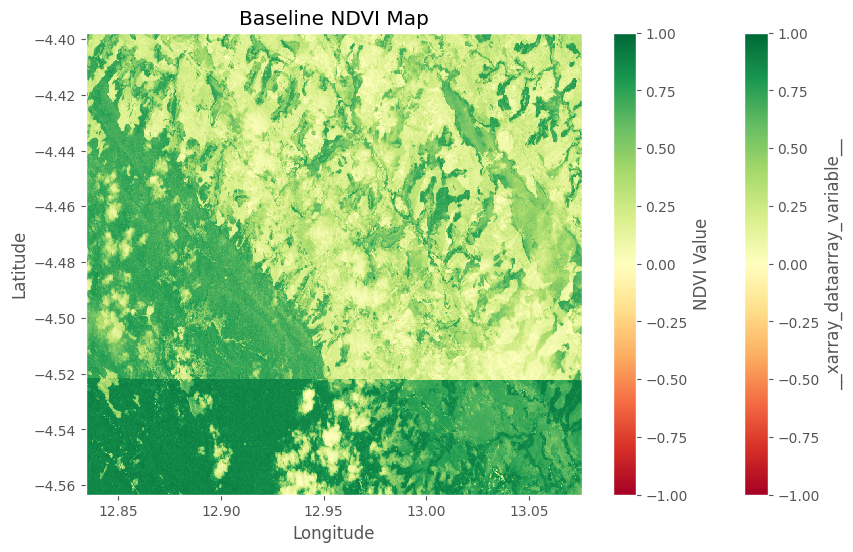

(<xarray.Dataset> Size: 9MB
 Dimensions:                        (band: 2, y: 859, x: 1250)
 Coordinates:
   * band                           (band) int32 8B 1 2
     spatial_ref                    int32 4B ...
   * x                              (x) float64 10kB 12.83 12.83 ... 13.08 13.08
   * y                              (y) float64 7kB -4.398 -4.398 ... -4.563
 Data variables:
     __xarray_dataarray_variable__  (band, y, x) float32 9MB dask.array<chunksize=(1, 859, 1250), meta=np.ndarray>,
 None)

In [56]:
# Load the baseline dataset
baseline_dataset_task = load_baseline_dataset(ZARR_STORE, group="kimongo-etl-job-baseline")

# Access NDVI DataArray and create a delayed task for the NDVI map
ndvi_data_task = baseline_dataset_task['__xarray_dataarray_variable__'][0, :, :].squeeze()

# Create a task to plot the NDVI map
ndvi_map_task = create_ndvi_map(ndvi_data_task)

# Compute the tasks
dask.compute(baseline_dataset_task, ndvi_map_task)

# Close the client when done
# client.close()